**Project Definition**

My project is future data prediction with deep learning models,
taking into account that time series data is affected by more than one time series data.
The data to be predicted in this project is cryptocurrencies.
This project aims to predict the future closing prices of cryptocurrencies.



The libraries used in the project are defined and the dataset is read.
Here I removed some attributes because I wrote a general function to calculate indicators, and I add them again from there.

Here I have tested about 30 datasets for other data by changing the location of the dataset and with other attributes by eliminating columns.


In [ ]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import gc
import keras
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
% matplotlib inline

data = pd.read_csv('/content/drive/MyDrive/bitirme/BTC/btcusd1ddominance2016-2019.csv')
data = data.set_index('time')
data.index = pd.to_datetime(data.index/1000, unit='s')
target_col = 'close'
data.drop(["MACD","MACDsig"],axis ='columns', inplace=True)
data


,open,close,high,low,volume,RSI,Dom
time,,,,,,,
2016-01-01 23:13:20,433.79,433.80,433.80,433.79,5.757400,NaN,91.32
2016-01-02 21:26:40,433.73,433.70,433.73,433.70,1.780218,NaN,91.35
2016-01-03 22:26:40,426.31,426.30,426.31,426.30,4.500000,NaN,91.29
2016-01-04 20:40:00,434.22,434.20,434.22,434.20,0.071477,NaN,91.22
2016-01-05 21:40:00,431.81,432.07,432.07,431.81,8.209369,NaN,91.31
...,...,...,...,...,...,...,...
2019-09-19 19:06:40,10056.00,10059.00,10059.00,10054.00,0.315802,44.613989,65.06
2019-09-20 17:20:00,10168.00,10168.00,10168.00,10168.00,0.031689,47.393674,64.84
2019-09-21 18:20:00,10004.00,10005.00,10005.00,10004.00,3.025000,43.849569,65.44


Dataset row number

In [ ]:
print('There are {} number of row in the dataset. '.format(data.shape[0]))

There are 1294 number of row in the dataset. 


Line graph representation of data


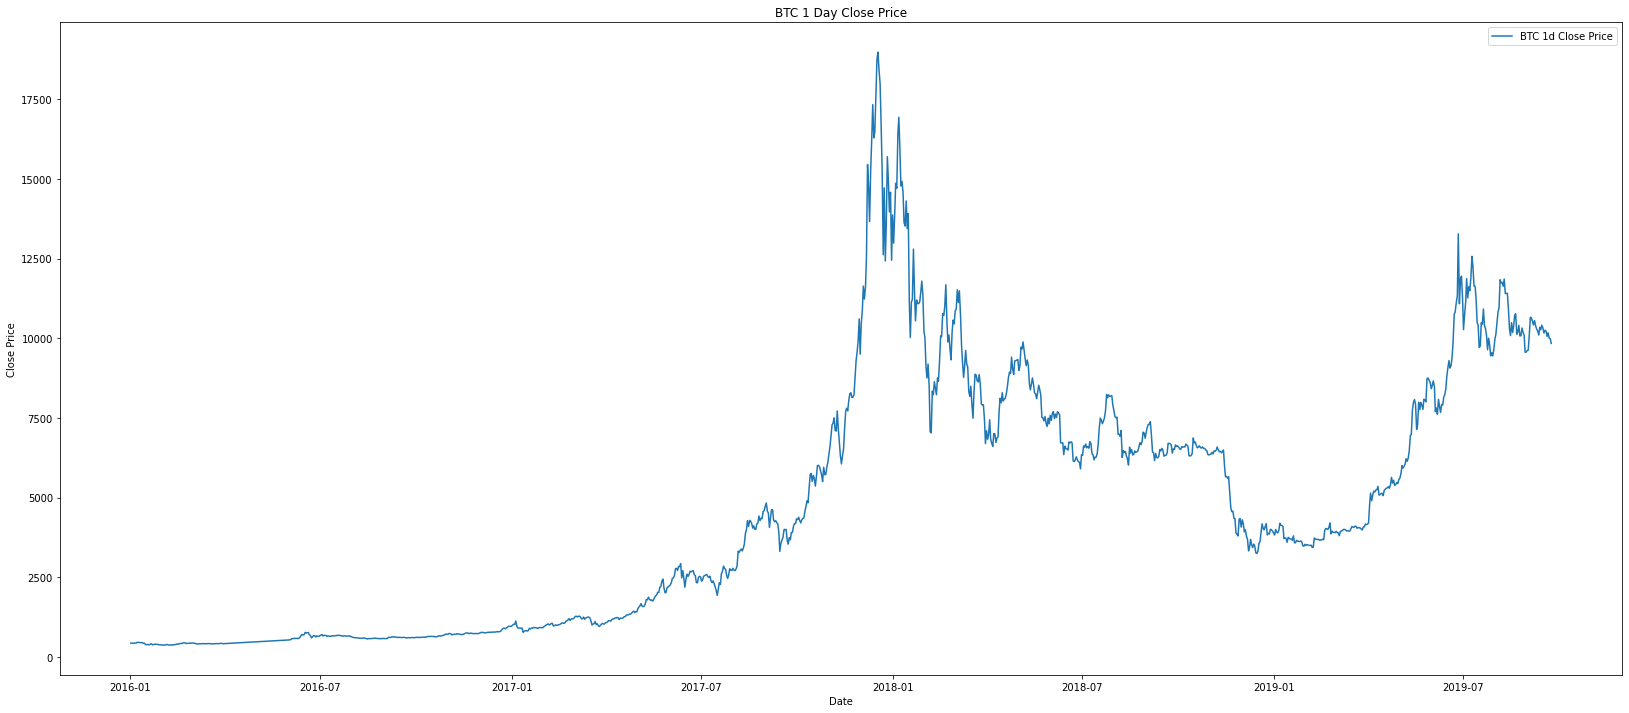

In [ ]:
plt.figure(figsize=(28, 12))#,dpi=100)
plt.plot(data.index, data['close'], label= 'BTC 1d Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('BTC 1 Day Close Price')
plt.legend()
plt.show()

Indicator calculation function 


In [ ]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['close'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['close'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['close'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['close']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])

    return dataset

In [ ]:
df = get_technical_indicators(data)


Deleting the data, which is empty field, for the model to work more healthily.


Display of indicators in datatable


In [ ]:
df=data
df =df.dropna()
df.tail()
df.head()

,open,close,high,low,volume,RSI,Dom,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
time,,,,,,,,,,,,,,,,,,
2016-01-21 21:00:00,407.89,407.56,407.89,407.56,0.200000,45.599718,90.41,391.762857,423.509048,415.463420,407.437538,-8.025882,25.343508,474.196063,372.822032,404.889949,406.56,6.007732
2016-01-22 22:00:00,377.13,376.66,377.13,376.66,11.984121,35.585855,90.44,390.044286,420.788095,411.941217,402.579405,-9.361812,27.183931,475.155957,366.420234,386.069983,375.66,5.928684
2016-01-23 23:00:00,387.58,387.20,387.58,387.14,10.211809,40.394192,90.07,390.574286,418.573810,409.732326,400.161489,-9.570837,27.962296,474.498402,362.649217,386.823328,386.20,5.956355
2016-01-24 21:13:20,401.20,401.21,401.21,401.20,0.140800,46.148506,89.79,392.420000,417.379048,408.982851,400.325780,-8.657071,28.151050,473.681147,361.076949,396.414443,400.21,5.991989
2016-01-25 22:13:20,391.61,391.61,391.61,391.61,0.537680,43.079528,89.61,393.224286,415.350952,407.475937,398.963981,-8.511956,28.411577,472.174107,358.527798,393.211481,390.61,5.967710


In [ ]:
def plot_technical_indicators(dataset,last_days):
  plt.figure(figsize=(16, 10), dpi=100)
  shape_0 = dataset.shape[0]
  xmacd_ =shape_0 -last_days
  
  dataset = dataset.iloc[-last_days:,:]
  x_ = range(3,dataset.shape[0])
  x_ = list(dataset.index)
  plt.figure(figsize=(30,20))
  # Plot first subplot
  plt.subplot(2, 1, 1)
  plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
  plt.plot(dataset['close'],label='Closing Price', color='b')
  plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
  plt.plot(dataset['upper_band'],label='Upper Band', color='c')
  plt.plot(dataset['lower_band'],label='Lower Band', color='c')
  plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
  plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
  plt.ylabel('USD')
  plt.legend()

  plt.figure(figsize=(30,20))
  plt.subplot(2,1,1)
  plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
  plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')
  plt.legend()
  
  plt.figure(figsize=(30,20))
  plt.subplot(2,1,1)
  plt.plot(dataset['RSI'],label='RSI', linestyle='-.')
  plt.show()

Display of indicators in graphs


<Figure size 1600x1000 with 0 Axes>

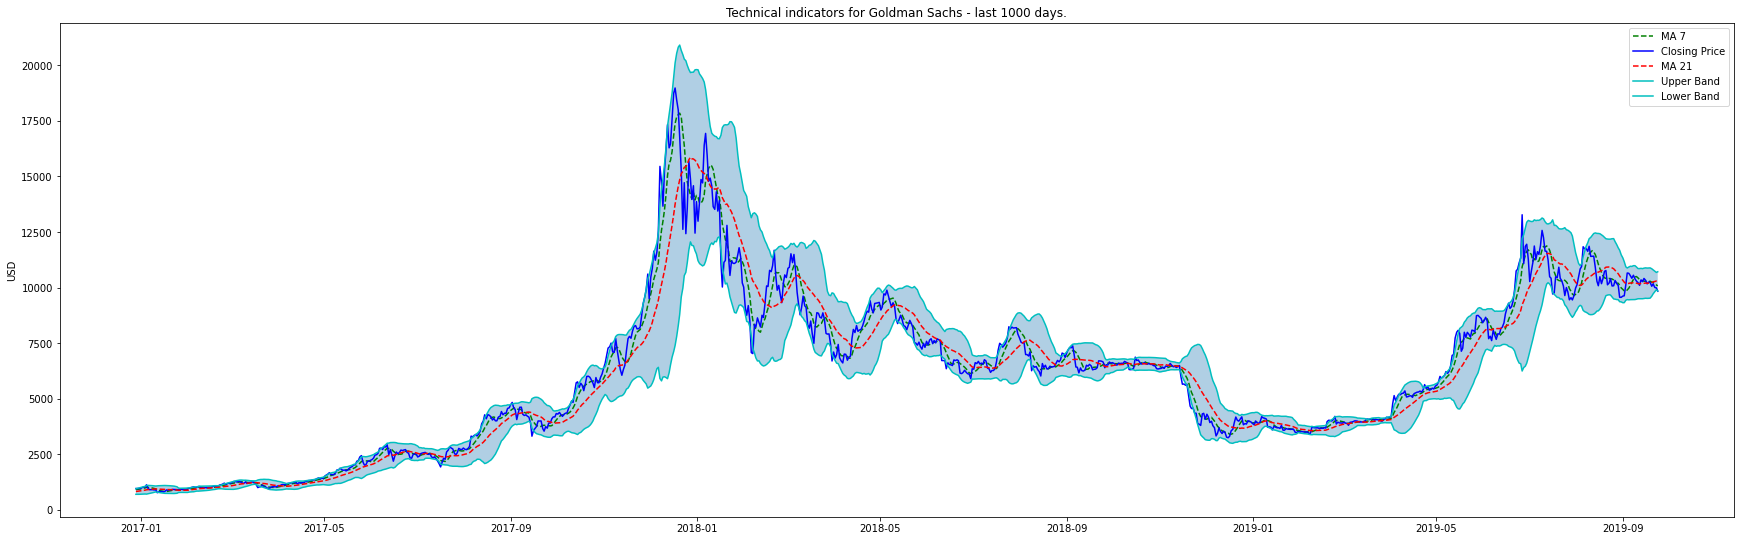

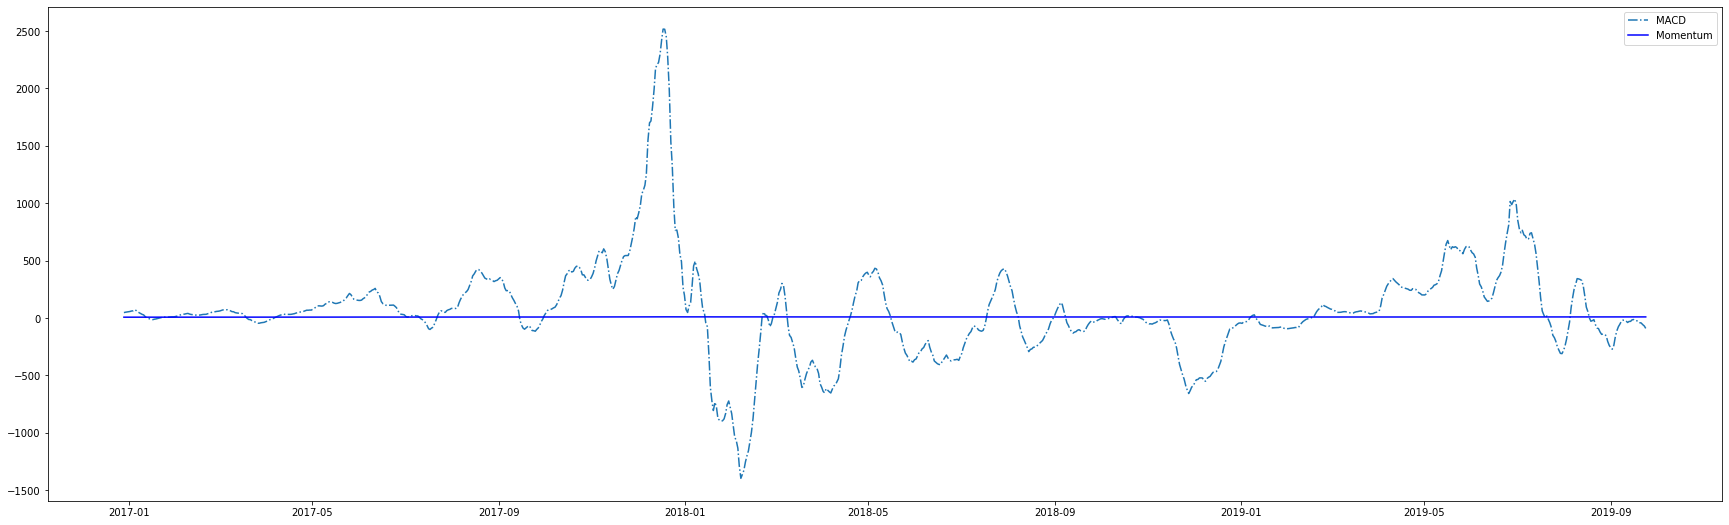

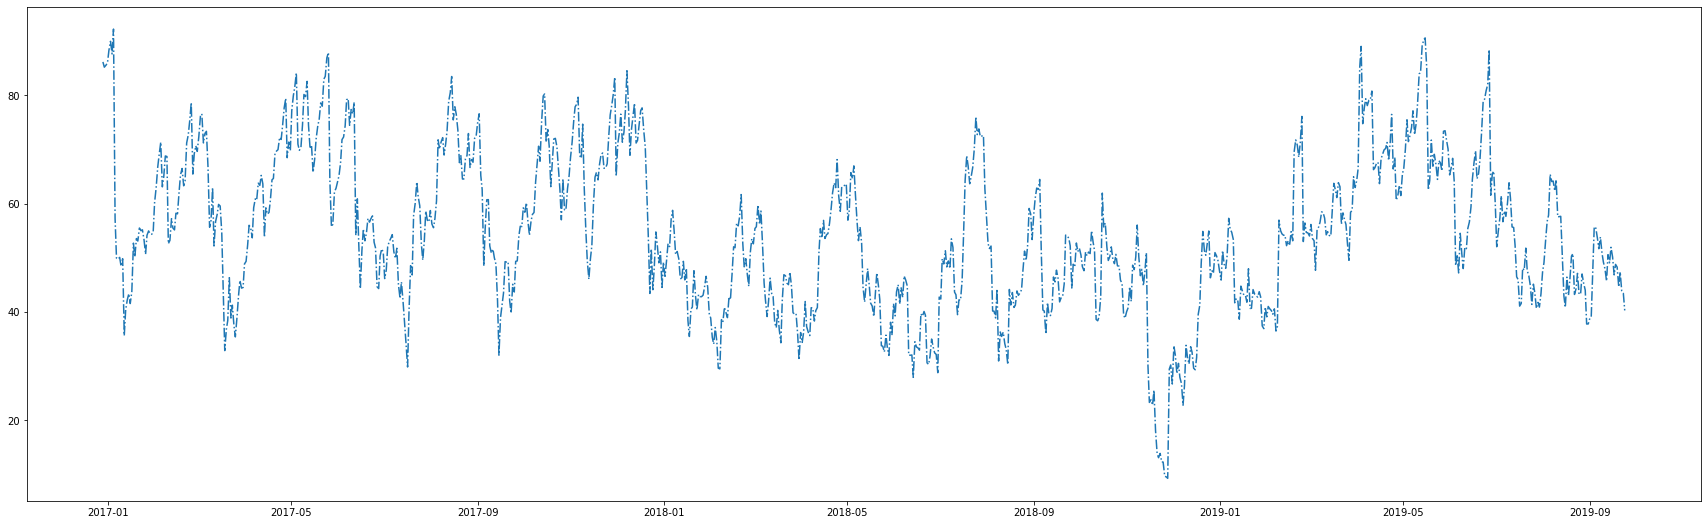

In [ ]:
plot_technical_indicators(df,1000)

Correlation observing the relationship between parameters in my dataset

when making predictions, even though classic stock analysis indicators often appear to correlate with prices. They were misleading.

Text(0.5, 1.0, 'Params')

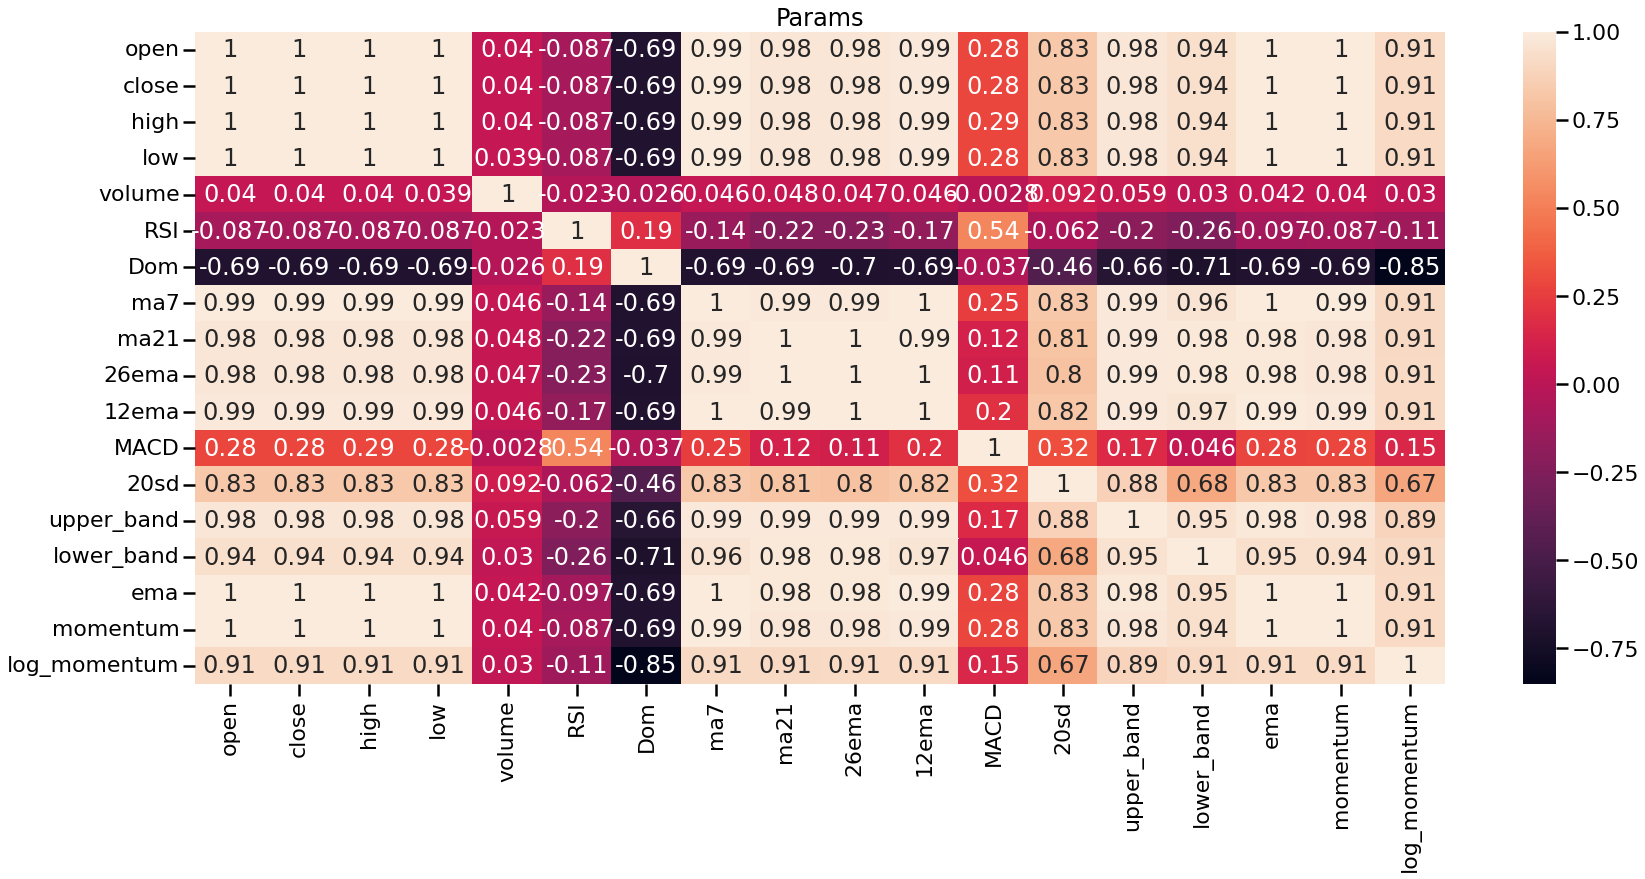

In [ ]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(df.corr(), annot = True).set_title('Params')

Total number of rows and number of features of my dataset.


In [ ]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 1274 samples, and 18 features.


In [ ]:
df.columns


Index(['open', 'close', 'high', 'low', 'volume', 'RSI', 'Dom', 'ma7', 'ma21',
       '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema',
       'momentum', 'log_momentum'],
      dtype='object')

The final state of the data table

In [ ]:
df

,open,close,high,low,volume,RSI,Dom,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
time,,,,,,,,,,,,,,,,,,
2016-01-21 21:00:00,407.89,407.56,407.89,407.56,0.200000,45.599718,90.41,391.762857,423.509048,415.463420,407.437538,-8.025882,25.343508,474.196063,372.822032,404.889949,406.56,6.007732
2016-01-22 22:00:00,377.13,376.66,377.13,376.66,11.984121,35.585855,90.44,390.044286,420.788095,411.941217,402.579405,-9.361812,27.183931,475.155957,366.420234,386.069983,375.66,5.928684
2016-01-23 23:00:00,387.58,387.20,387.58,387.14,10.211809,40.394192,90.07,390.574286,418.573810,409.732326,400.161489,-9.570837,27.962296,474.498402,362.649217,386.823328,386.20,5.956355
2016-01-24 21:13:20,401.20,401.21,401.21,401.20,0.140800,46.148506,89.79,392.420000,417.379048,408.982851,400.325780,-8.657071,28.151050,473.681147,361.076949,396.414443,400.21,5.991989
2016-01-25 22:13:20,391.61,391.61,391.61,391.61,0.537680,43.079528,89.61,393.224286,415.350952,407.475937,398.963981,-8.511956,28.411577,472.174107,358.527798,393.211481,390.61,5.967710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-19 19:06:40,10056.00,10059.00,10059.00,10054.00,0.315802,44.613989,65.06,10243.142857,10227.761542,10278.011104,10236.731380,-41.279724,309.025966,10845.813474,9609.709609,10116.524965,10058.00,9.216124
2019-09-20 17:20:00,10168.00,10168.00,10168.00,10168.00,0.031689,47.393674,64.84,10229.142857,10256.623328,10269.862133,10226.157322,-43.704812,269.504271,10795.631871,9717.614785,10150.841655,10167.00,9.226902
2019-09-21 18:20:00,10004.00,10005.00,10005.00,10004.00,3.025000,43.849569,65.44,10171.285714,10275.142376,10250.242716,10192.133118,-58.109598,234.360103,10743.862581,9806.422171,10053.613885,10004.00,9.210740


The Prepare Data function takes the data as a parameter, the feature to be predicted, windows len, zero base, and the ratio required to divide the data into train and test.

First of all, the data is divided into train and test. I parse my data with the window method and collect it in a dataframe. Then I normalize, so I put my data in a smaller range. Afterwards, I return my datasets that I have prepared

In [ ]:
def prepare_data(df,target_col,window_len=10,zero_base = True, test_size=0.2):
  train_data,test_data = train_test_split(df,test_size=test_size)
  x_train = extract_window_data(train_data,window_len,zero_base)
  x_test = extract_window_data(test_data,window_len,zero_base)
  y_train = train_data[target_col][window_len:].values
  y_test = test_data[target_col][window_len:].values
  if zero_base:
    y_train = y_train / train_data[target_col][:-window_len].values -1
    y_test = y_test / test_data [target_col][:-window_len].values-1
    
  return train_data,test_data, x_train,x_test,y_train,y_test

def train_test_split (df,test_size=0.2):
  split_row = len(df)- int (test_size* len(df))
  train_data=df.iloc[:split_row]
  test_data=df.iloc[split_row:]
  return train_data,test_data

def extract_window_data(df,window_len=5,zero_base=True):
  window_data=[]
  for idx in range (len(df)-window_len):
    tmp = df[idx: (idx+window_len)].copy()
    if zero_base:
      tmp = normalise_zero_base(tmp)
    window_data.append(tmp.values)
  return np.array(window_data)

def normalise_zero_base(df):
  return df / df.iloc[0] -1 

def normalise_min_max(df):
  return (df -df.min())/ (df.max() - df.min())

data_training,data_testing,X_train,X_test,y_train, y_test = prepare_data(df,target_col,window_len=60,zero_base=True,test_size=0.2)
x_test, y_test = np.array(X_test), np.array(y_test)
print("x_test :" ,x_test.shape)
print("y_test :" ,y_test.shape)
print("X_train:", X_train.shape)

x_test : (194, 60, 18)
y_test : (194,)
X_train: (960, 60, 18)


**Build Model**

I am preparing my Lstm model. My model is sequential model, I used 100 as the number of neourans, and I found this number of neons by trial and error method.
The parameters here are passed as hyperparametre

ı want to explain hyberparametre.

+Dropout is a threshold value. It does not use nodes below the threshold value in fully connected layers. This ensures that weak information is forgotten. Forgetting weak information increases learning.

Dense
+Dense:Each node at the input is connected to each node at the output.

Activation 
+It contains activation functions, it determines the output value according to the activation function

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('linear'))

**Model Summary**

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


Epoch
Epoch is the number of turns. While the model is being trained, not all data are included in the training at once. It is included in the training by dividing along the epoch number.

Batch size
Batch size is required for batch processing. The dataset is divided into parts according to the batch size and the model is trained on this part at each step. The important point here is the random data selection of the part selection.

OPtimization 
In deep learning applications, there is an optimization problem at the root of the learning process. Some methods are used to find the optimum value in the solution of nonlinear problems. These methods are called optimization methods.


I appeared manually while specifying the epoch. I tried very high and very low and decided that 20 was the most suitable.

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
from datetime import datetime
start_time = datetime.now()
hi=model.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test), batch_size = 32, verbose=1)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


Epoch 1/20
30/30 [==============================] - 6s 24ms/step - loss: 0.1710 - val_loss: 0.0407
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0639 - val_loss: 0.0345
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0520 - val_loss: 0.0282
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0429 - val_loss: 0.0334
Epoch 5/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0433 - val_loss: 0.0278
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0349 - val_loss: 0.0220
Epoch 7/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0333 - val_loss: 0.0223
Epoch 8/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0269 - val_loss: 0.0144
Epoch 9/20
30/30 [==============================] - 0s 6ms/step - loss: 0.0254 - val_loss: 0.0141
Epoch 10/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0293 - val_loss: 0.0165
Epoch 11/20
30/30 

Burada Epoch sayısına göre Loss ve validation loss grafiğini gözlemledim. Bu grafik bana optimum epoch sayısını veriyor. Aynı zamanda modelin öğrenmesinin tur sayısıyla artığını gösteriyor.


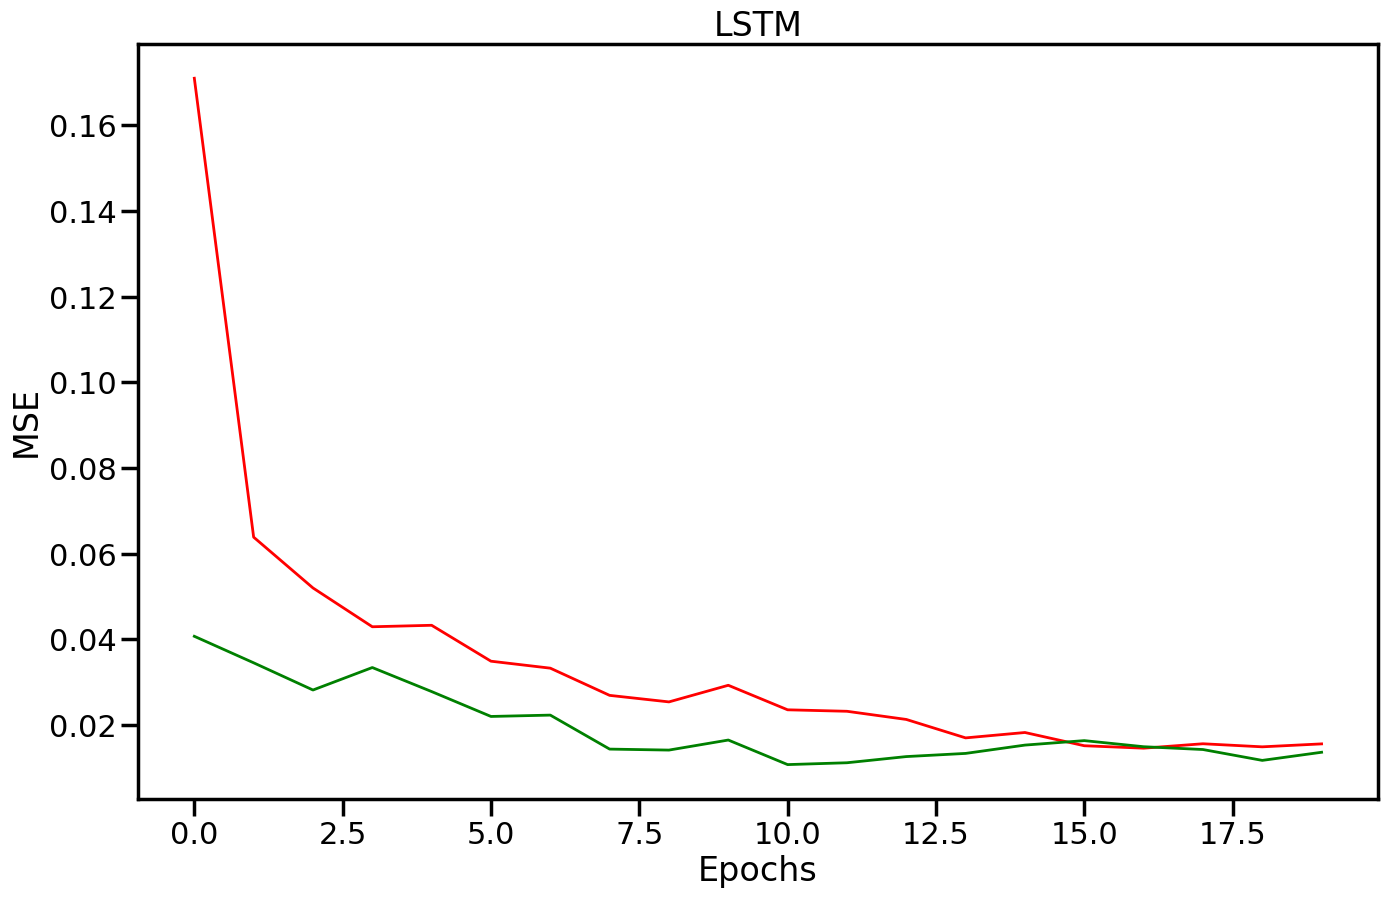

In [ ]:
plt.figure(figsize=(16, 10), dpi=100)
plt.plot(hi.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(hi.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()


**Prediction**

Şimdi tahmin kısmındayız elimdeki test datasını vererek tahmin gerçekleştiriyor.

In [ ]:
y_pred= model.predict(X_test).squeeze()

**Model Performance Measurement**
I'm calculating six metrics here about how the model works 

**Mean absolute error**

Predicted Close Price difference with actual close price data

**Mean square error**

Predicted Close Price difference with actual close price data

**Model evaluation**

It is for evaluating the pre-trained model. Returns the loss value and measurement values for the model.

**RMSE**

Root Mean Square Error (RMSE) is the square root of the MSE. It is used more often than MSE because sometimes the MSE value can be too large to be easily compared. Therefore, the MSE is calculated with the square of the error, thus facilitating interpretation.

**R2 score**

Within a data set, higher R-squared values represent smaller differences between observed data and predicted values. It is not a sufficient metric on its own. In some cases it can be misleading.


Since I am using a linear lstm model, as an accurancy calculation, I made an additional calculation such as 1- loss value to the indicators here.


In [ ]:
from sklearn.metrics import mean_absolute_error,accuracy_score,r2_score,mean_squared_error

acc= model.evaluate(X_test, y_test)
print("Model Evaluate : " , acc)

temp=0
counter =0 
for aa in hi.history['loss']:
  temp = temp + aa
  counter = counter + 1

accurany = 1-(temp/counter)
print("Accurany (1-Loss value) :%.2f%%" %(accurany*100))

MAE=mean_absolute_error(y_pred, y_test)
print("Mean Absolute Error = ", MAE )

MSE=mean_squared_error(y_pred, y_test)
print("Mean Squared Error = " , MSE)
RMSE = math.sqrt(MSE)
print("RMSE = " ,RMSE)

R2=r2_score(y_test, y_pred)
print("R2 score : ", R2)

from csv import writer
import csv

row=['BTC1d:open,close,low,high,volume,BTC_Close,all_indicator',acc,MAE ,MSE,R2]
print(row)
with open('/content/drive/MyDrive/bitirme/BTC/btcPreReport.csv','a',encoding='UTF8') as f:
     writer = csv.writer(f)
     writer.writerow(row)


7/7 [==============================] - 0s 5ms/step - loss: 0.0136
Model Evaluate :  0.013627556152641773
Accurany (1-Loss value) :96.49%
Mean Absolute Error =  0.07656455225251053
Mean Squared Error =  0.013627555138479597
RMSE =  0.11673711979691634
R2 score :  0.8971494818157134
['BTC1d:open,close,low,high,volume,BTC_Close,all_indicator', 0.013627556152641773, 0.07656455225251053, 0.013627555138479597, 0.8971494818157134]


I revert the process of compressing the data I made at the beginning to a certain value range and bring the data back to its old format.

In [ ]:
targets = data_testing[target_col][60:]
preds = data_testing[target_col].values[:-60] * (y_pred + 1)
preds = pd.Series(index=targets.index, data=preds)


Finally, I show the actual close price and the predicted close price on a bi line graph and write the results to the file.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


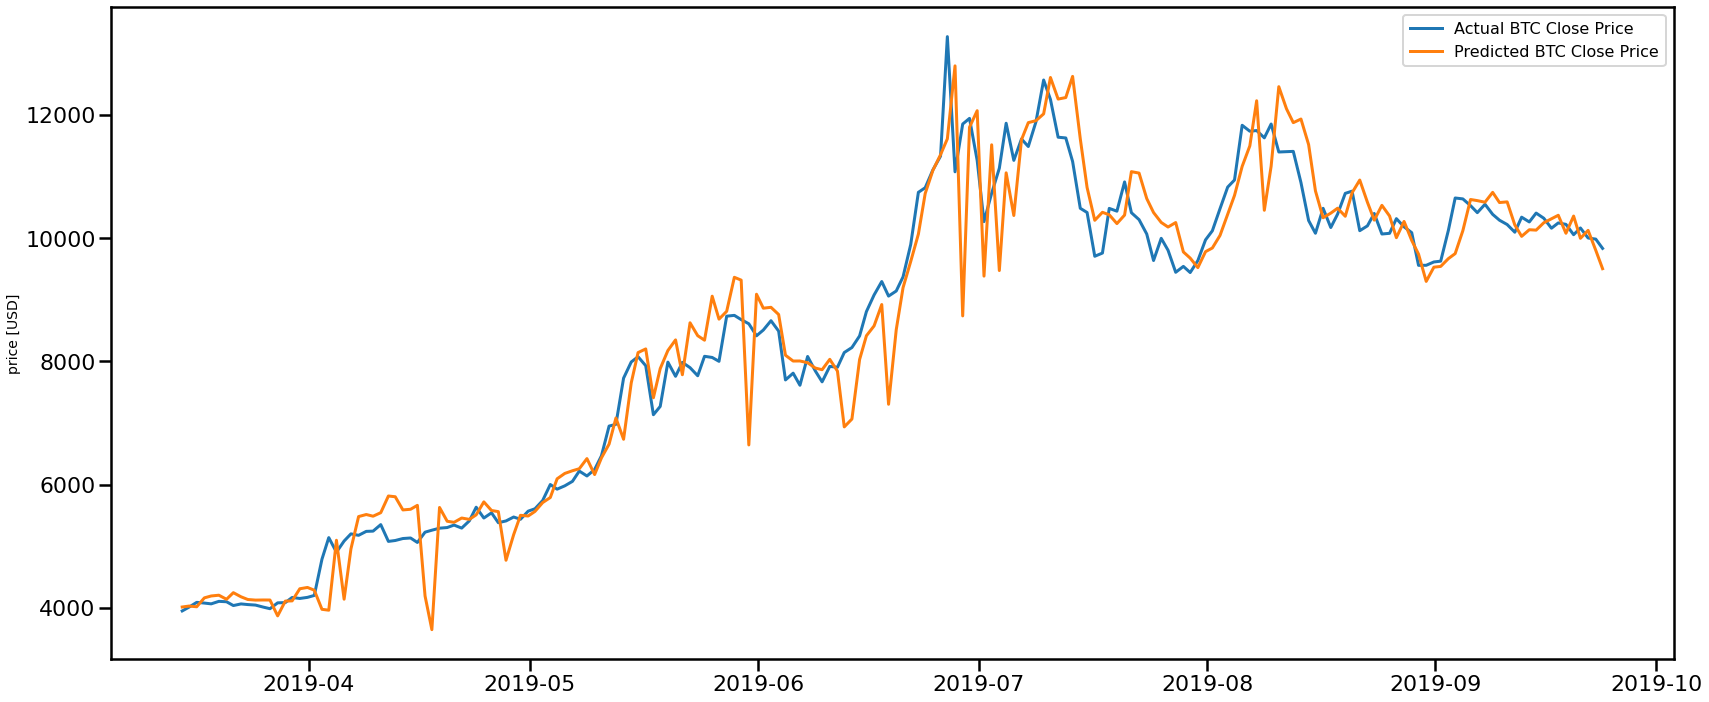

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
  fig,ax = plt.subplots(1,figsize=(28,12))
  ax.plot(line1, label=label1, linewidth=lw)
  ax.plot(line2, label=label2, linewidth=lw)
  ax.set_ylabel('price [USD]',fontsize=14)
  ax.set_title(title,fontsize=16)
  ax.legend(loc='best',fontsize=16)

df['Classic_prediction']=preds
line_plot(targets,preds,'Actual BTC Close Price','Predicted BTC Close Price',lw=3)
df.to_csv('/content/drive/MyDrive/bitirme/BTC/PREBTC/BTCusd1dpre.csv',index='time')
